## **1. simpleNN**

### **Neural network diagram**

nn.svg

### Expanation


### **Excutable codes**
(a series of results will show up anytime you make it fire.  )

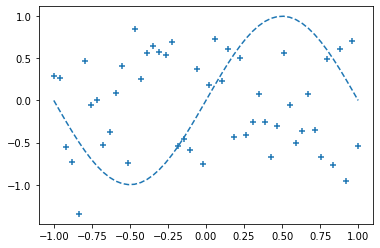

Epoch:0/4001 Accuracy:0.5448302850571929


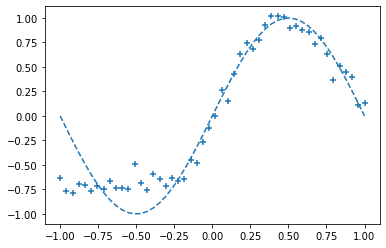

Epoch:400/4001 Accuracy:0.9768475682084407


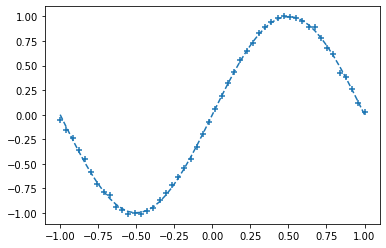

Epoch:800/4001 Accuracy:0.9998201520718668


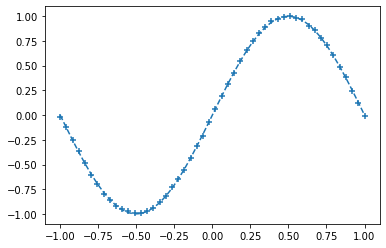

Epoch:1200/4001 Accuracy:0.9999650076553612


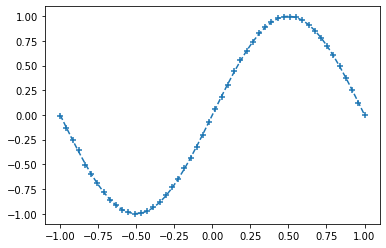

Epoch:1600/4001 Accuracy:0.9999782533206977


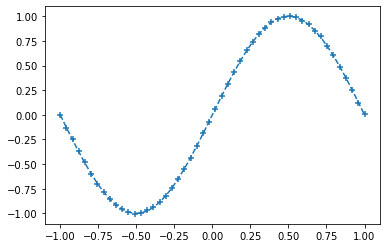

Epoch:2000/4001 Accuracy:0.9999869213186341


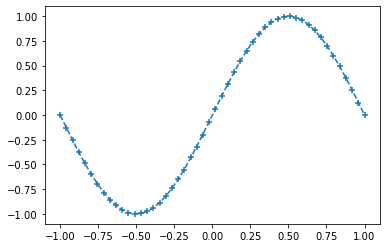

Epoch:2400/4001 Accuracy:0.9999918105080572


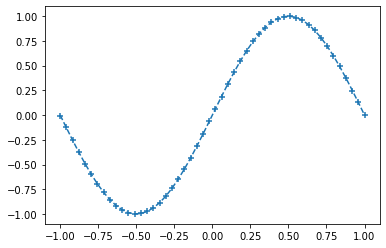

Epoch:2800/4001 Accuracy:0.9999949130420613


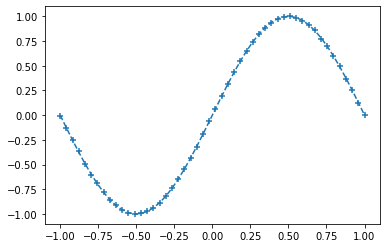

Epoch:3200/4001 Accuracy:0.9999929343730337


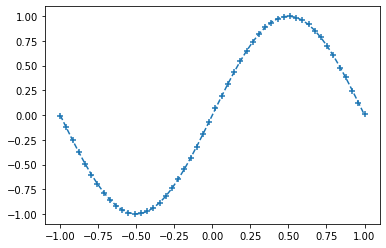

Epoch:3600/4001 Accuracy:0.9999902720798218


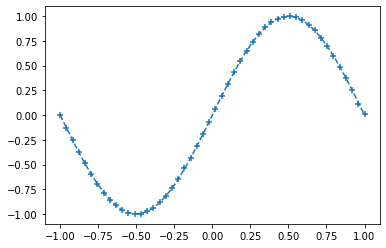

Epoch:4000/4001 Accuracy:0.9999932537643436


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -- generate original input data and define correct data --
input_data = np.linspace(-np.pi, np.pi)  # original input dataset
correct_data = np.sin(input_data)        # correct dataset
input_data = input_data/np.pi            # normalize the data realm from -1.0 to 1.0
n_data = len(correct_data)               # total numbers(lengths) of data

# -- config --
n_in = 1   # the number of neurons at the input layer
n_mid = 12 # the number of neurons at the hidden layers
n_out = 1  # the number of neurons at the output layer

wb_width = 0.60  # initial width of weight and bias
eta = 0.18       # initial learning coefficient
epoch = 4001     # online batch, meaning its size is one.
interval = 400    # initial monitoring interval

# -- super-class --
class BaseLayer:
    def __init__(self, n_upper, n): #initializer (n_upper: the numbers of neurons in the upper(prior) layer, n: the numbers of neurons in its own layer)
        self.w = wb_width * np.random.randn(n_upper, n)  # weight matrix (normalized)
        self.b = wb_width * np.random.randn(n)  # bias vector (normalized)

    def update(self, eta): # method for updating weight and bias
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- sub-class #1--
# -- hiddenlayer--
class HiddenLayer(BaseLayer):
    def forward(self, x):  # method for foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b # u = X * W +B
        self.y = 1/(1+np.exp(-u))  # use sigmoid function for activaion

    def backward(self, grad_y):  # method for backward-propagation
        delta = grad_y * (1-self.y)*self.y  # delta = gradient of sigmoid function
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward
        self.grad_b = np.sum(delta, axis=0) # take gradient of bias backward
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer

# -- sub-class #2--
# -- output layer --
class OutputLayer(BaseLayer):
    def forward(self, x):  # method for foreward-propagation
        self.x = x 
        u = np.dot(x, self.w) + self.b  # u = X * W + B
        self.y = u   # use identity function for activation 

    def backward(self, t):  # method for backward-propagation
        delta = self.y - t # delta = y - t (raw loss)
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward
        self.grad_b = np.sum(delta, axis=0) # take gradient of bias backward
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer


# -- initializing each layer --
hidden_layer1 = HiddenLayer(n_in, n_mid)
hidden_layer2 = HiddenLayer(n_mid, n_mid)
hidden_layer3 = HiddenLayer(n_mid, n_mid)
hidden_layer4 = HiddenLayer(n_mid, n_mid)

output_layer = OutputLayer(n_mid, n_out)

# -- start learning --
for i in range(epoch):

    # shffle the indecies of arrays of input and their corresponding correct data to make learning order randamized
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # preparation for plotting the results
    total_error = 0
    plot_x = []
    plot_y = []

    for idx in index_random:

        x = input_data[idx]  # original input dataset
        t = correct_data[idx]  # correct dataset

        # foreward-propagation
        hidden_layer1.forward(np.array([[x]]))  # treat input dataset as a matrix(that consists of just one number, though.)
        hidden_layer2.forward(hidden_layer1.y)
        hidden_layer3.forward(hidden_layer2.y)
        hidden_layer4.forward(hidden_layer3.y)
        output_layer.forward(hidden_layer4.y)

        # backward-propagation
        output_layer.backward(np.array([[t]]))  # treat correct dataset as a matrix(that consists of just one number, though.)
        hidden_layer4.backward(output_layer.grad_x)
        hidden_layer3.backward(hidden_layer4.grad_x)
        hidden_layer2.backward(hidden_layer3.grad_x)
        hidden_layer1.backward(hidden_layer2.grad_x)

        # update weight and bias (method of update defined in the class BaseLayer)
        hidden_layer1.update(eta)
        hidden_layer2.update(eta)
        hidden_layer3.update(eta)
        hidden_layer4.update(eta)
        output_layer.update(eta)

        if i%interval == 0:

            y = output_layer.y[0][0]  # get a number (from matrix) as a learned one in the output layer.

            # error estimation by loss function (apply mean square error)
            total_error += 1.0/2.0*np.sum(np.square(y - t))

            # store outputs learned
            plot_x.append(x)
            plot_y.append(y)

    if i%interval == 0:

        # plot outpus
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()

        # print epoch number and errors
        print("Epoch:" + str(i) + "/" + str(epoch), "Accuracy:" + str(1 - total_error/n_data))